Define headers

In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Define Dataset

In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2
from PIL import Image

def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
#         print(filename)
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

Confirm if datasets works

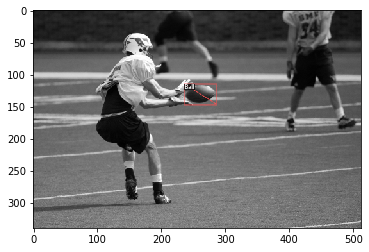

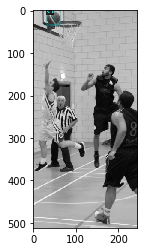

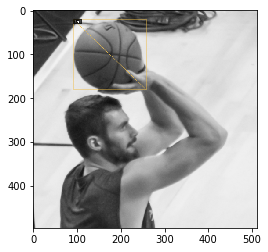

In [6]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")
# print (dataset_dicts)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [7]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch
torch.cuda.set_device(2)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 5001    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[02/03 14:57:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[02/03 14:57:59 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[02/03 14:57:59 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Ball    | 6845         |
|            |              |
[02/03 14:57:59 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/03 14:57:59 d2.data.build]: Using training sampler TrainingSampler
[02/03 14:58:00 d2.engine.train_loop]: Starting training from iteration 5001
[02/03 14:58:00 d2.engine.hooks]: Total training time: 0:00:00 (0:00:00 on hooks)


OrderedDict()

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

(288, 384, 3)

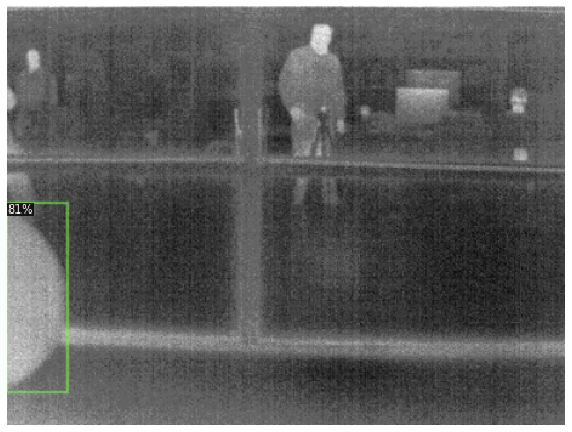

In [9]:
im = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag_2cam/thermic/1579790238028925357.png")

outputs = predictor(im)
# print(outputs["instances"].scores, outputs["instances"].pred_boxes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

results=outputs["instances"].to("cpu")
# results.pred_boxes.tensor[0].numpy()
im.shape

(1440, 1920, 3)

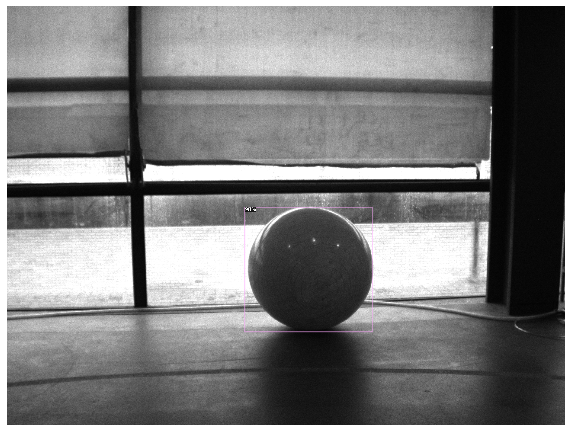

In [10]:
im_rgb = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag2/RGB/1580394991253331379.png")

outputs2 = predictor(im_rgb)

v = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])
im_rgb.shape

In [11]:
# cameraMatrix=[[708.30536, 0, 170.51079],
#  [0, 714.59424, 130.0705],
#  [0, 0, 1]]
from detectron2.utils.visualizer import ColorMode
import numpy as np
import time

d_real=0.63 *1000#m

cameraMatrix_IR=np.array([[725.790155, 0, 191.397201],
[0, 733.580771, 149.464123],
[0, 0, 1]])

print(cameraMatrix_IR)

fx=cameraMatrix_IR[0][0]
fy=cameraMatrix_IR[1][1]
cx=cameraMatrix_IR[0][2]
cy=cameraMatrix_IR[1][2]
print(fx,fy,cx,cy)

[[725.790155   0.       191.397201]
 [  0.       733.580771 149.464123]
 [  0.         0.         1.      ]]
725.790155 733.580771 191.397201 149.464123


In [76]:
cameraMatrix_RGB=np.array([[2168.684845,0,965.374725],
[0,2180.313918,699.133011],
[0,0,1]])

# cameraMatrix_mono=np.array([[2477.329635,0,1164.282877],
# [0,2488.879238,786.821399],
# [0,0,1]])

# cameraMatrix_RGB=cameraMatrix_mono

print(cameraMatrix_RGB)

fx_rgb=cameraMatrix_RGB[0][0]
fy_rgb=cameraMatrix_RGB[1][1]
cx_rgb=cameraMatrix_RGB[0][2]
cy_rgb=cameraMatrix_RGB[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

[[2.16868485e+03 0.00000000e+00 9.65374725e+02]
 [0.00000000e+00 2.18031392e+03 6.99133011e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
2168.684845 2180.313918 965.374725 699.133011


41


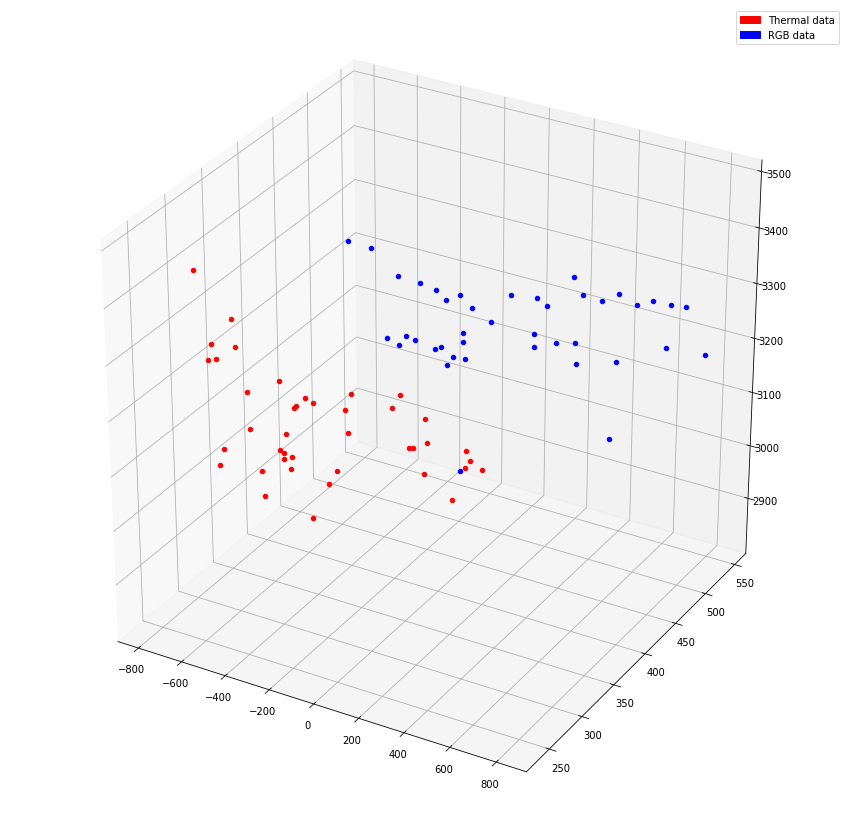

In [77]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
#read txt files with image path
# txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/bag2/", "bag2_rgb.txt")
txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")

f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
f_ir = open(txt_file_ir, "r")

#iniciate 3d plot
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='blue', label='RGB data')
red_patch = mpatches.Patch(color='red', label='Thermal data')
plt.legend(handles=[red_patch,blue_patch])

#initiate vectors
Xt=[]
Yt=[]
Zt=[]
Xr=[]
Yr=[]
Zr=[]
xpi=[]
ypi=[]
xpr=[]
ypr=[]
c=0

#for each figure in the path
for line_rgb in f_rgb: 
# read images and calculate detected bounding box for each camera
    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")

# CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_rgb)!=0 and len(results_ir)!=0 ):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
        cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.05*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.05*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

        if(cond1==False and cond2==False):
            #VISUAL
            xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
            yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
            xc_rgb=float("%0.2f"%xc_rgb)
            yc_rgb=float("%0.2f"%yc_rgb)

            dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
            dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
            d_pix_rgb=(dx_rgb+dy_rgb)/2

            Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
            X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
            Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb

            ax.scatter(X_rgb, Y_rgb, Z_rgb, c='b') #draw in plot
            #IR
            xc=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
            yc=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
            xc=float("%0.2f"%xc)
            yc=float("%0.2f"%yc)

            dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix=(dx+dy)/2

            Z_ir=((fx+fy)/2)*(d_real/d_pix)
            X_ir=(Z_ir*(xc-cx))/fx
            Y_ir=(Z_ir*(yc-cy))/fy

            #append points
#             xpr.append(xc_rgb)
#             ypr.append(yc_rgb)
#             xpi.append(xc)
#             ypi.append(yc)
            Xr.append(X_rgb)
            Yr.append(Y_rgb)
            Zr.append(Z_rgb)
            Xt.append(X_ir)
            Yt.append(Y_ir)
            Zt.append(Z_ir)        

            ax.scatter(X_ir, Y_ir, Z_ir, c='r') #draw in plot
            
            c+=1
#             print("RGB coordinates: (%f,%f,%f)" % (X_rgb,Y_rgb,Z_rgb))
#             print("Thermal coordinates: (%f,%f,%f)" % (X_ir,Y_ir,Z_ir))
        
f_ir.close()        
f_rgb.close()
print(c)

/home/danielarato/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


41


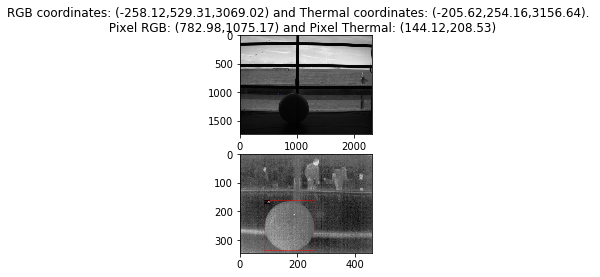

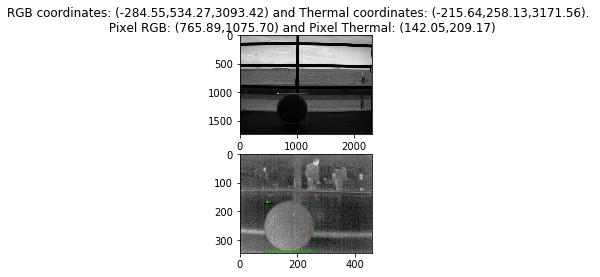

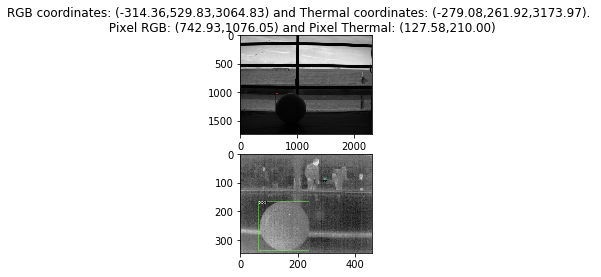

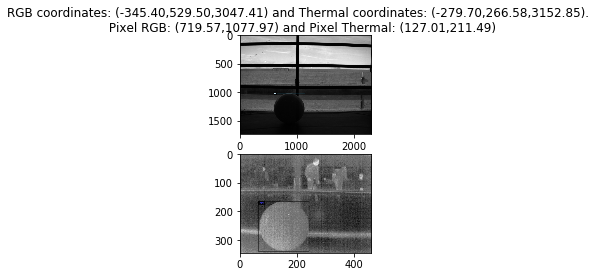

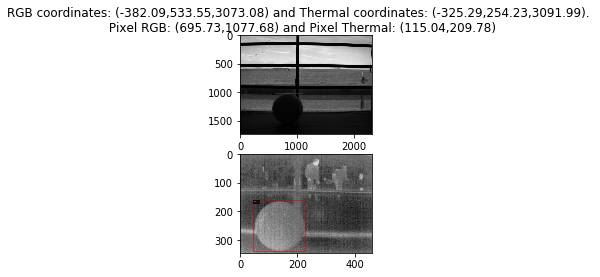

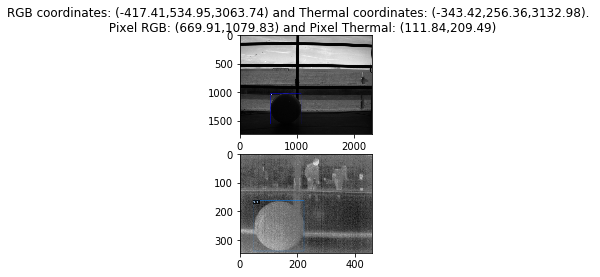

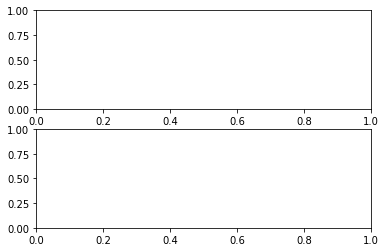

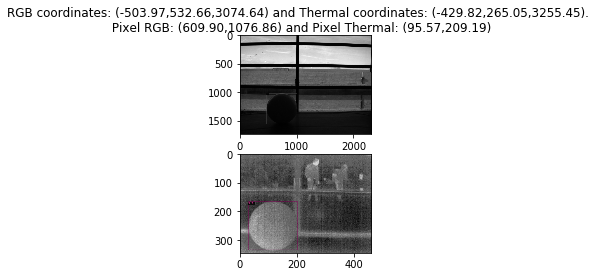

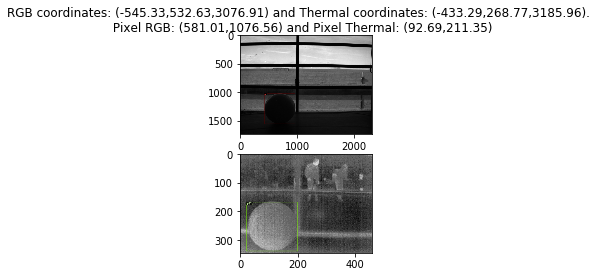

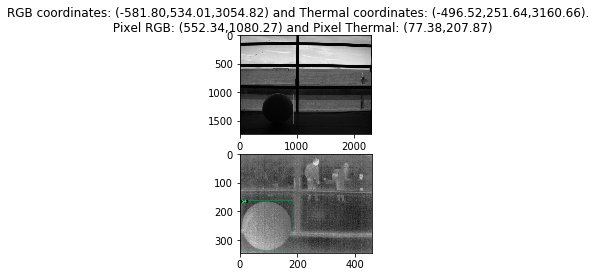

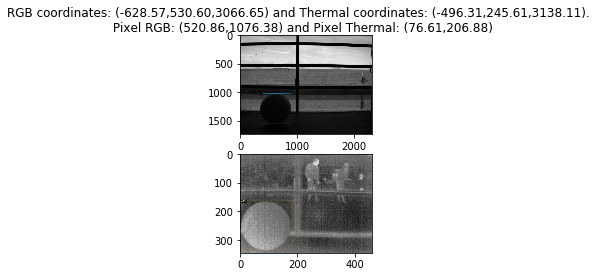

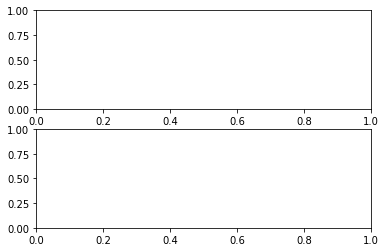

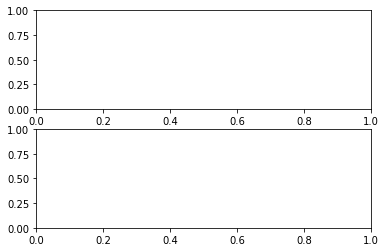

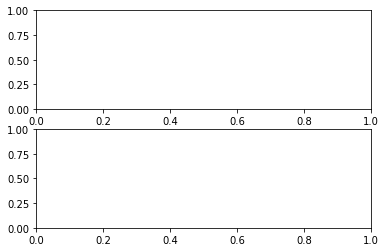

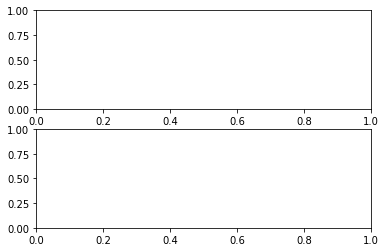

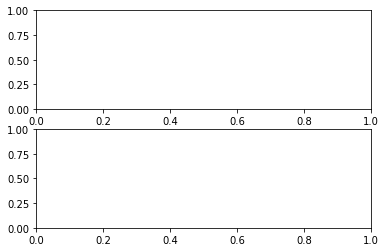

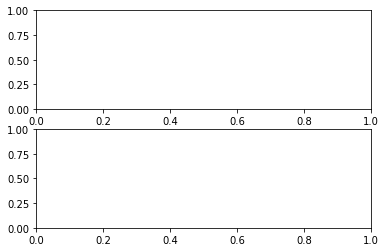

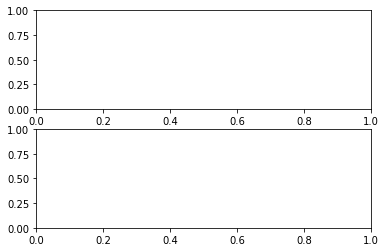

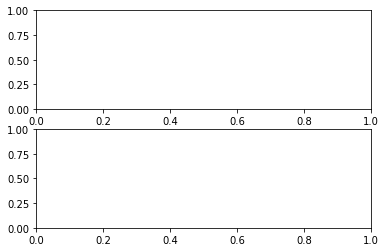

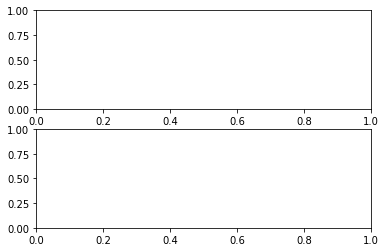

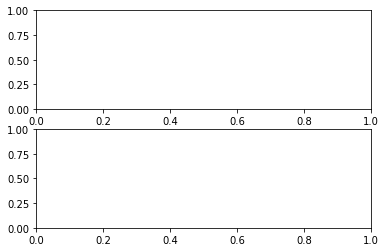

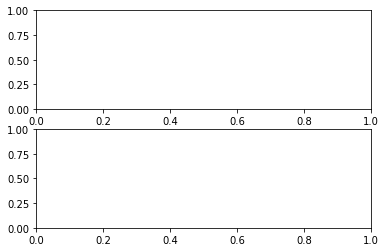

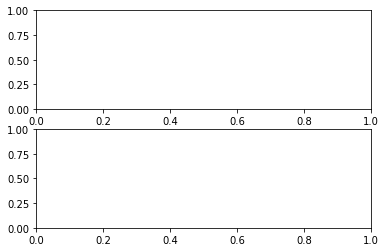

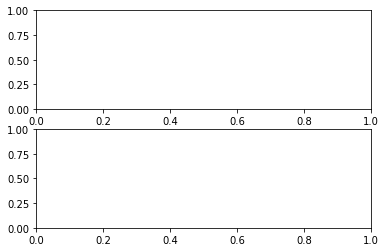

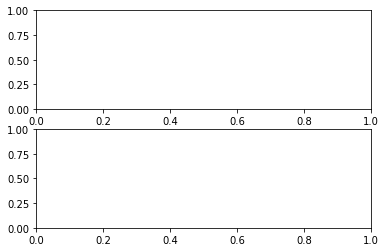

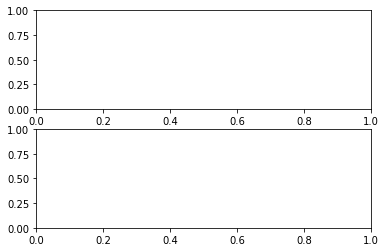

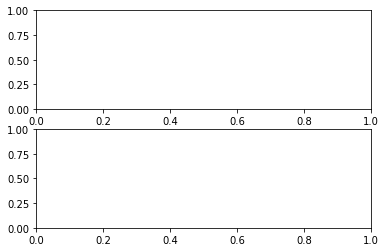

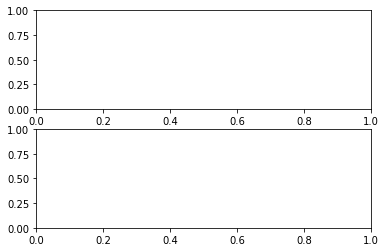

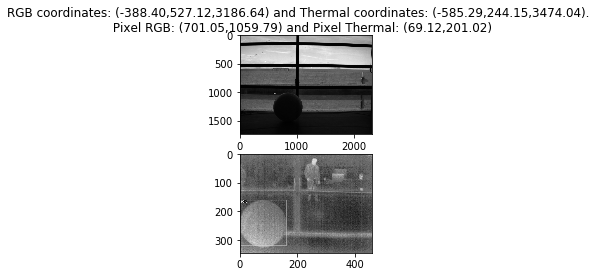

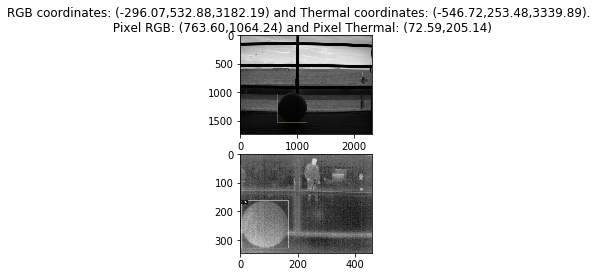

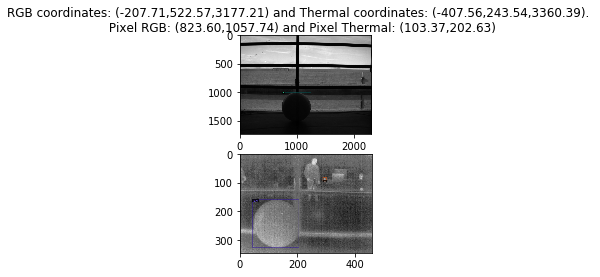

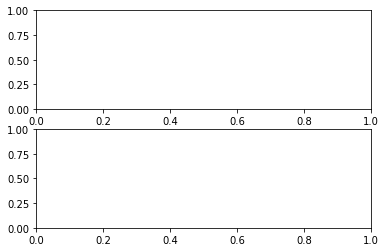

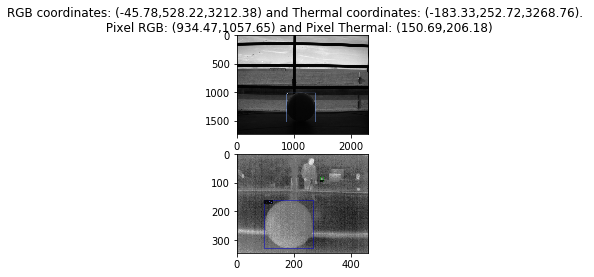

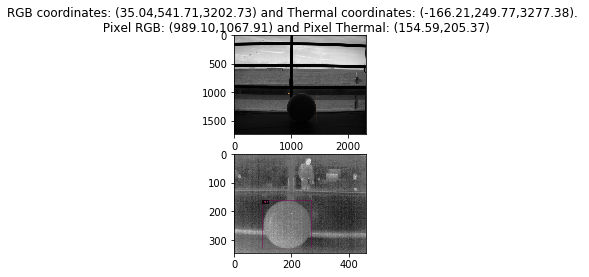

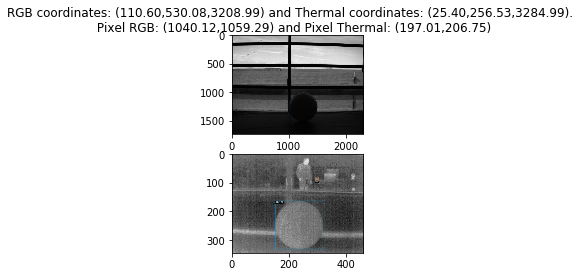

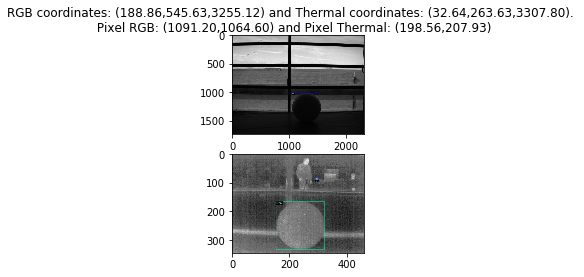

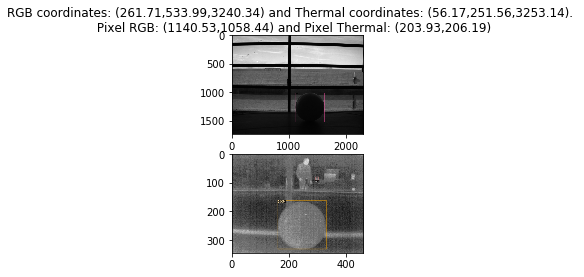

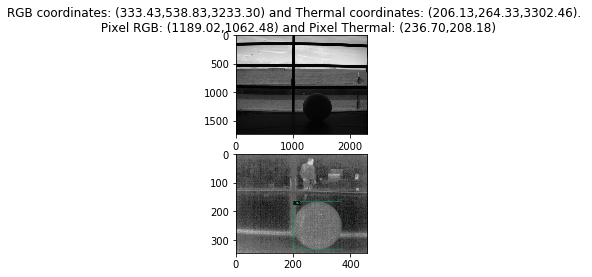

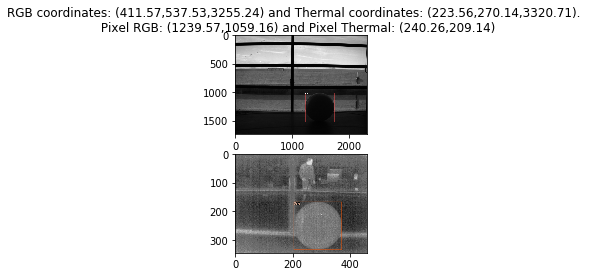

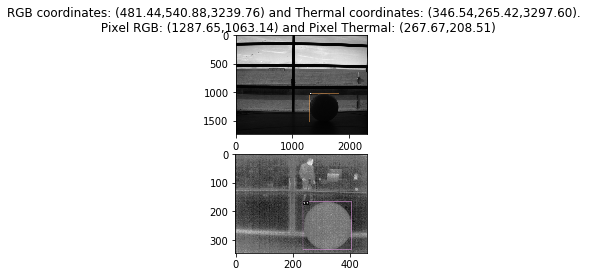

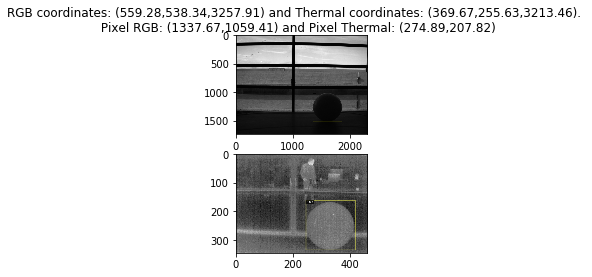

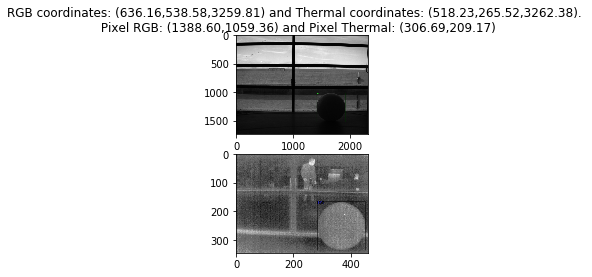

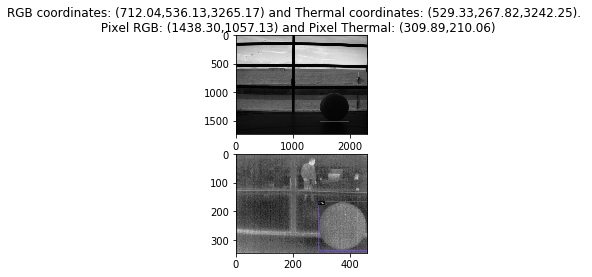

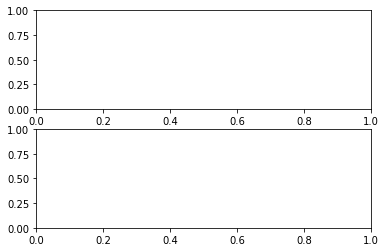

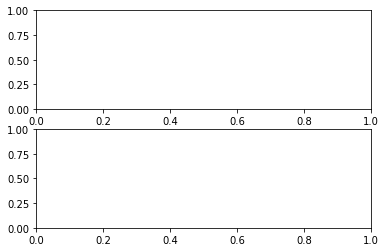

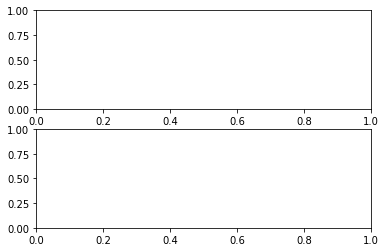

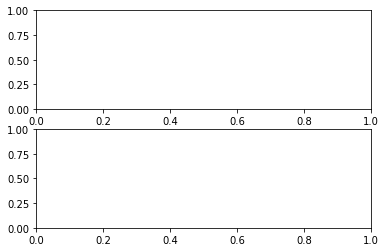

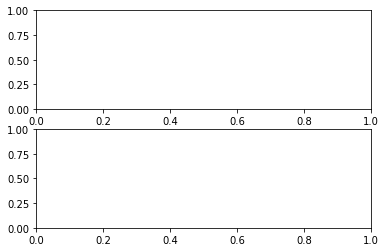

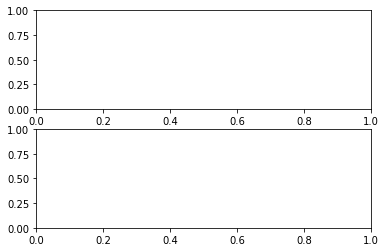

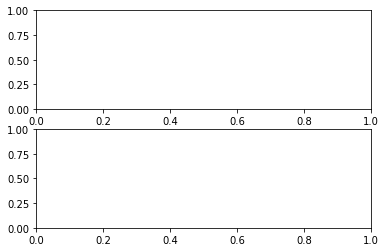

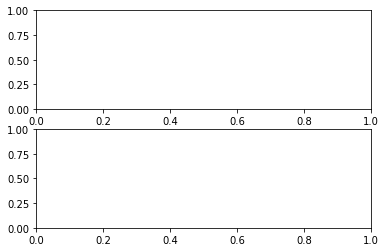

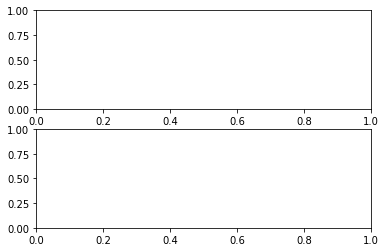

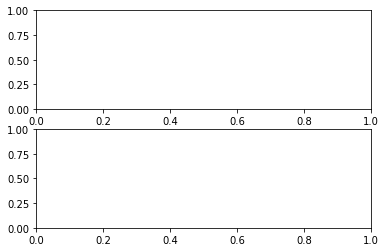

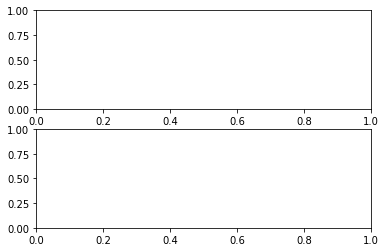

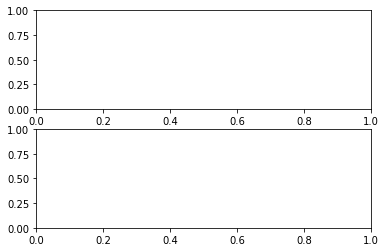

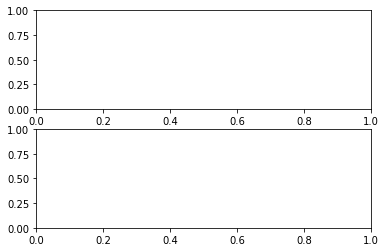

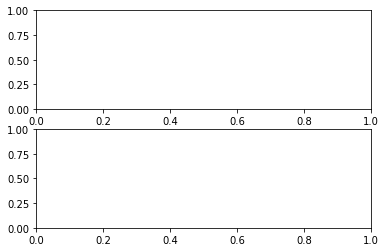

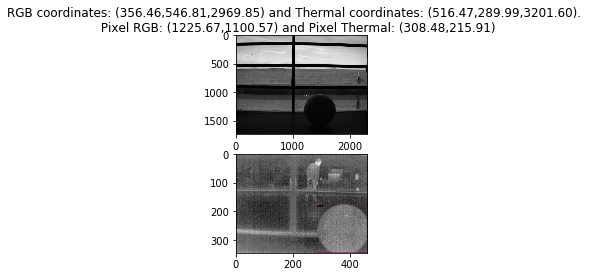

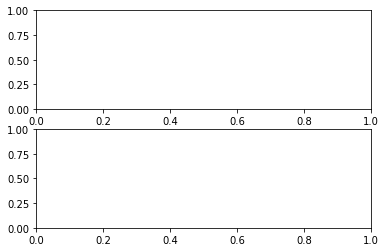

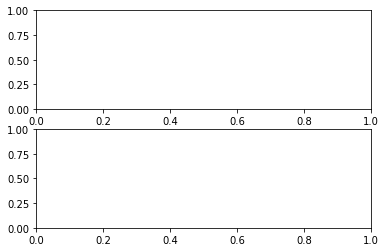

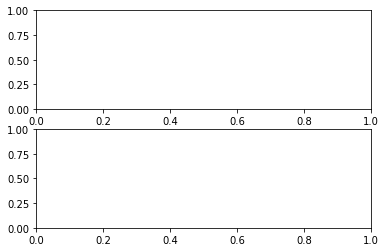

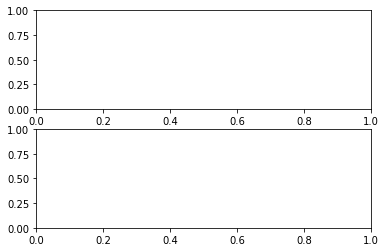

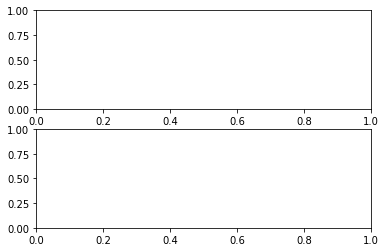

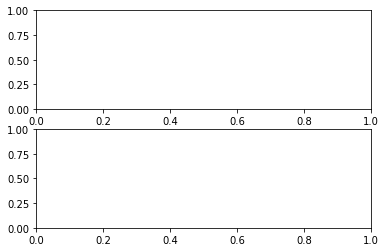

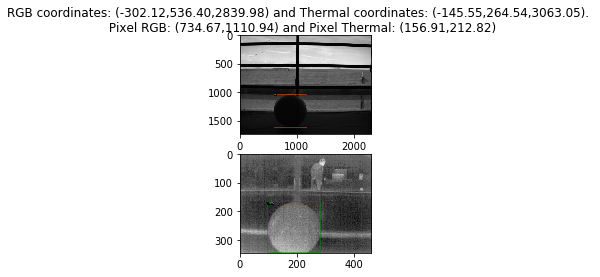

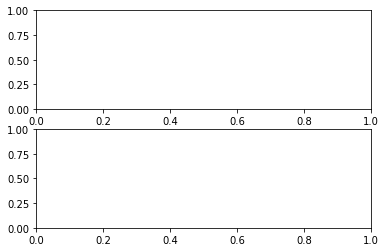

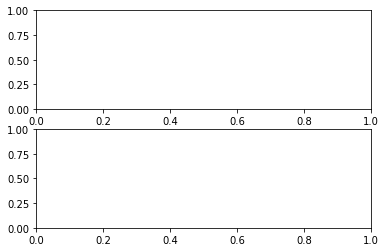

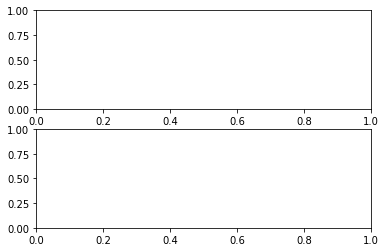

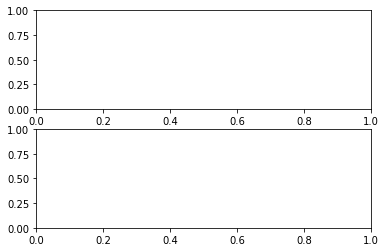

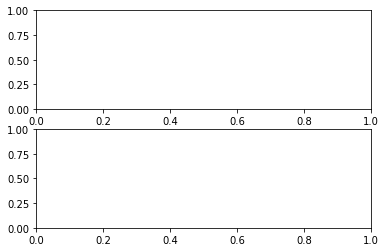

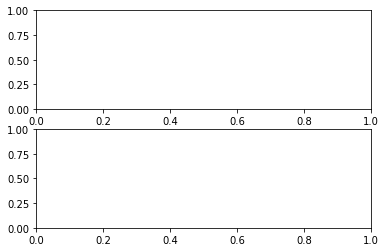

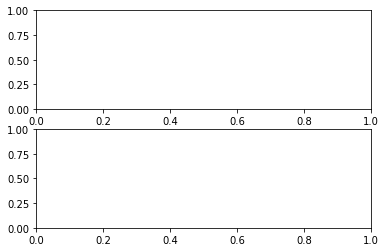

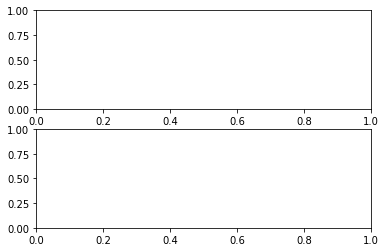

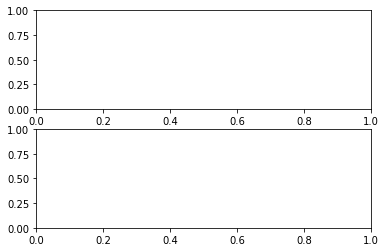

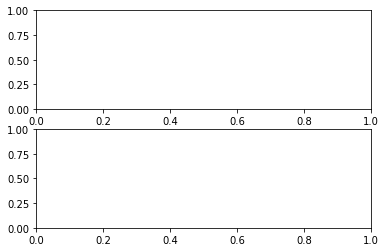

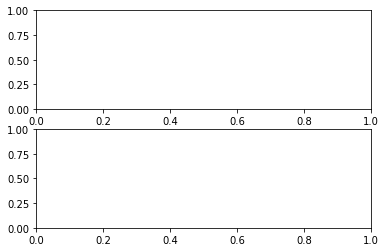

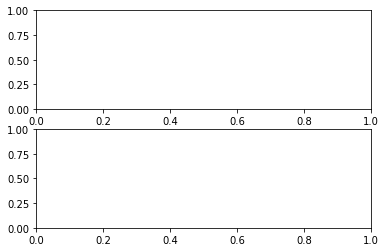

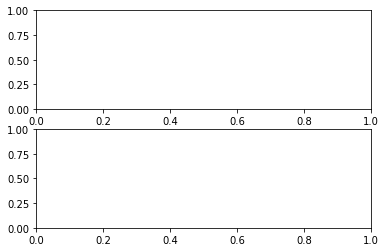

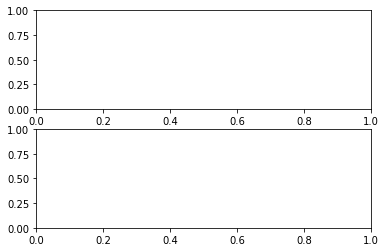

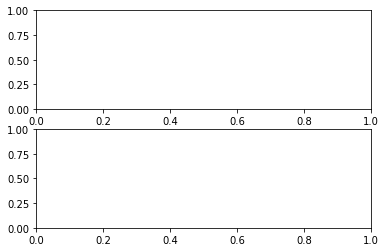

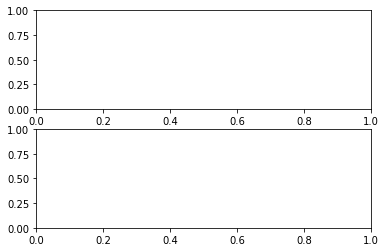

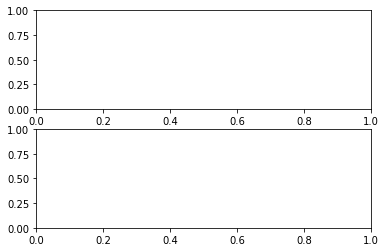

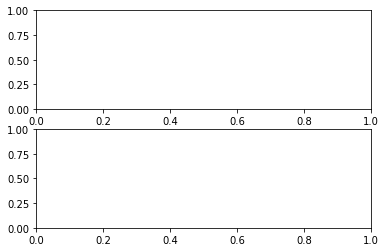

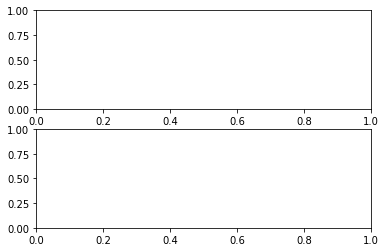

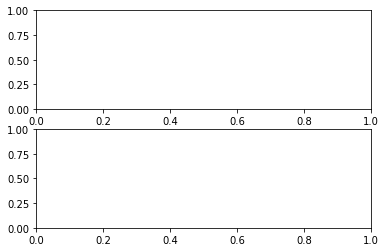

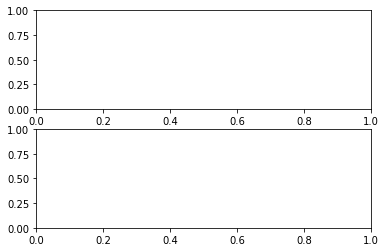

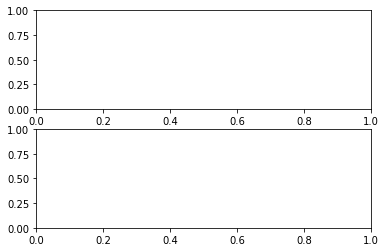

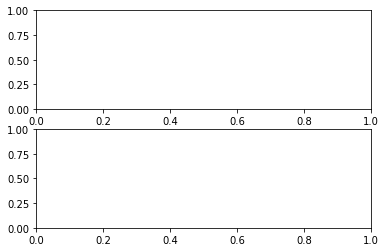

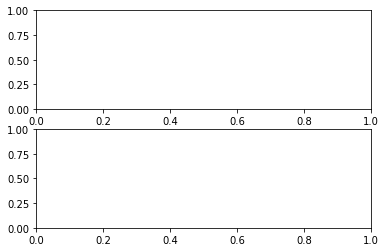

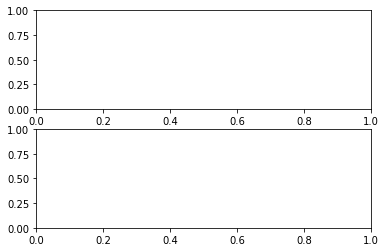

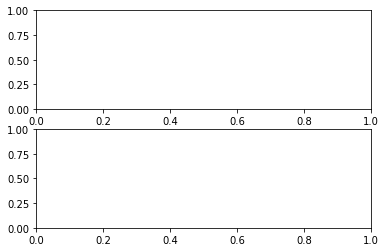

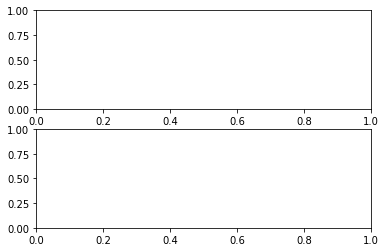

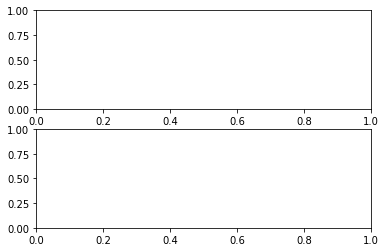

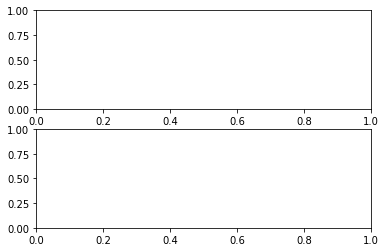

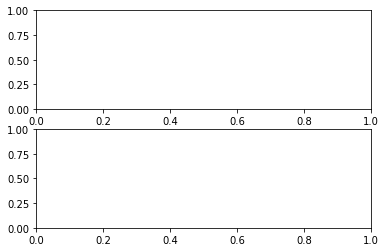

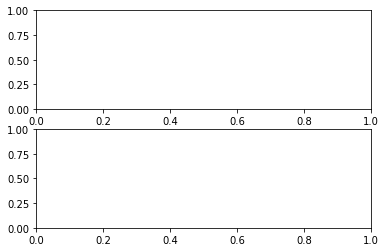

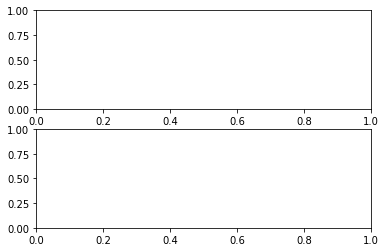

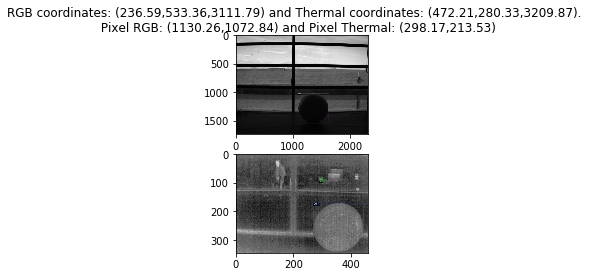

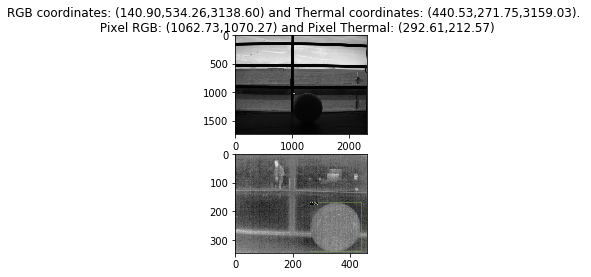

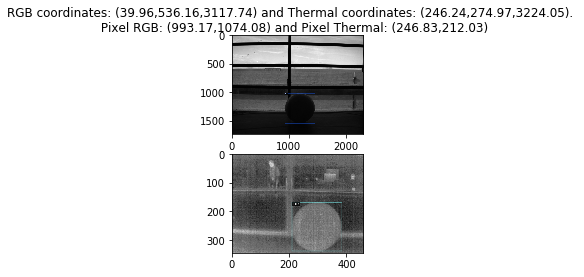

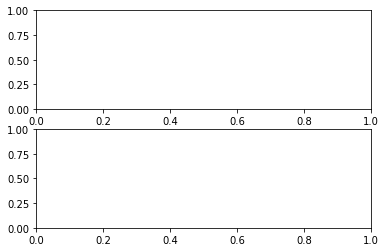

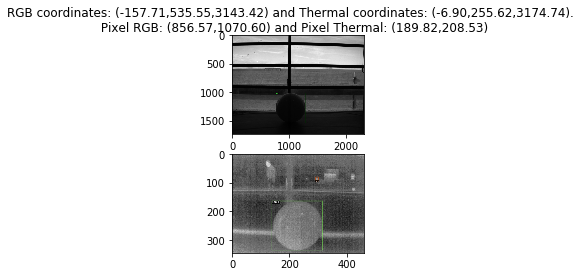

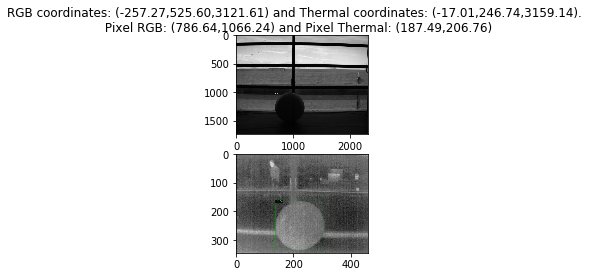

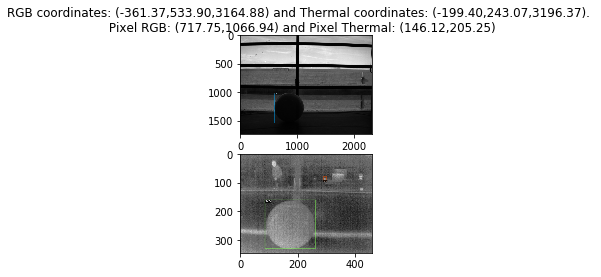

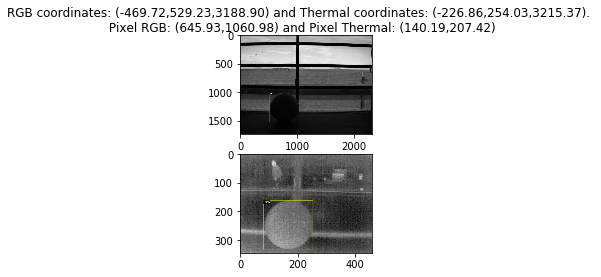

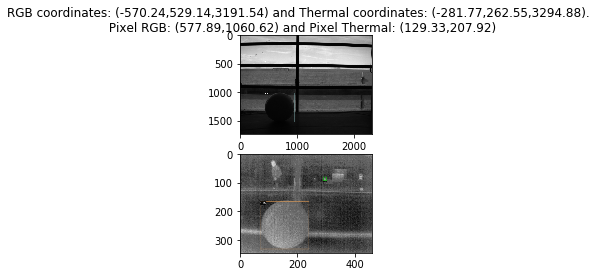

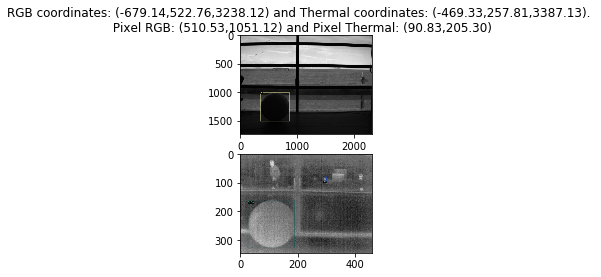

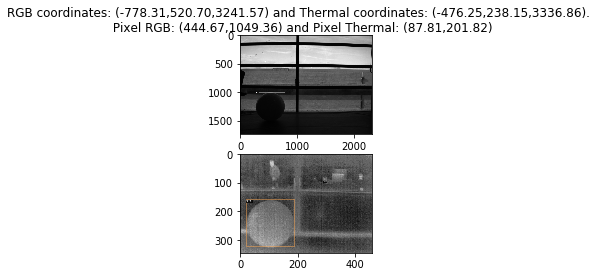

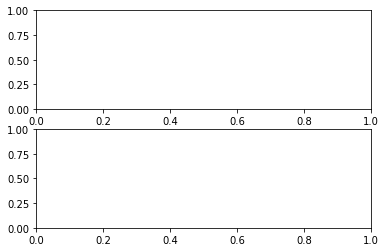

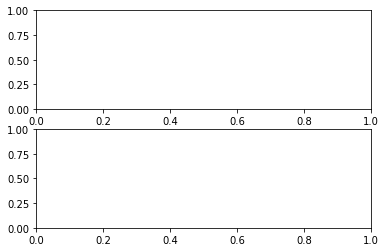

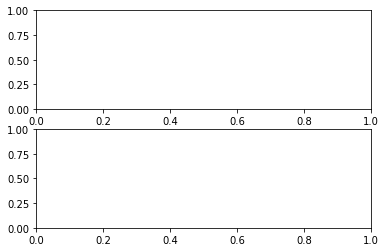

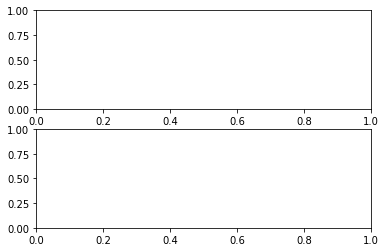

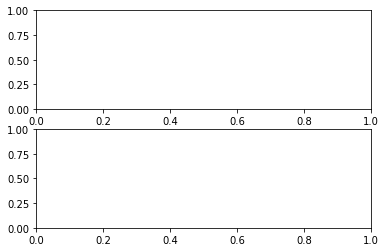

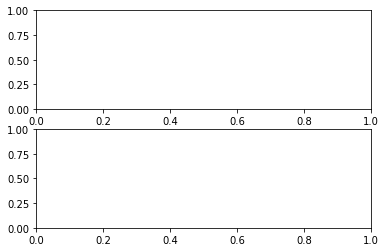

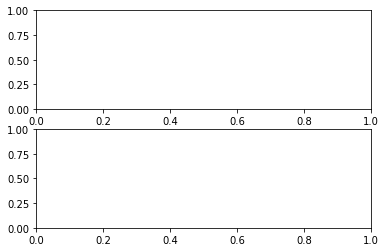

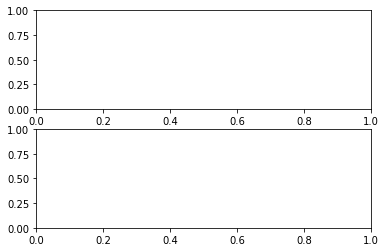

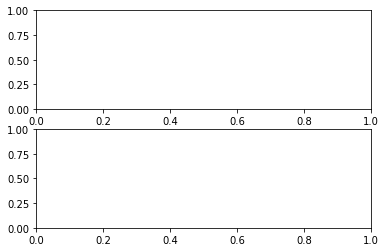

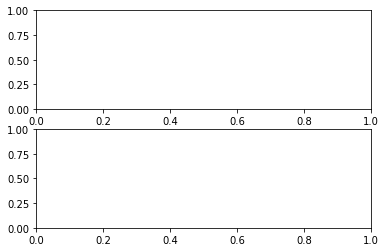

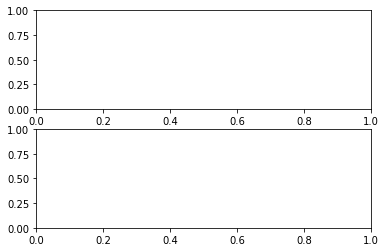

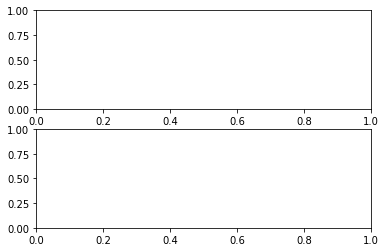

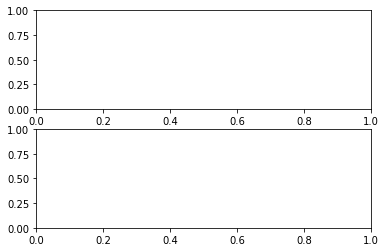

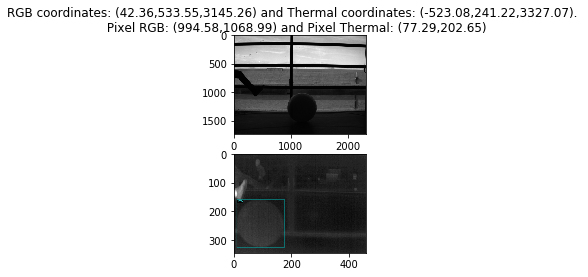

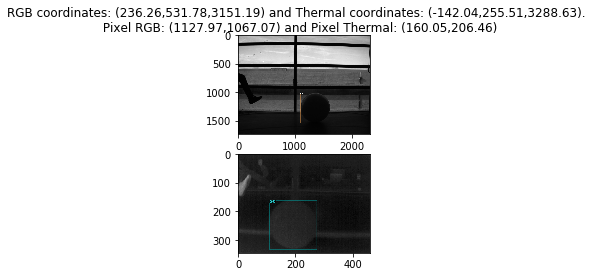

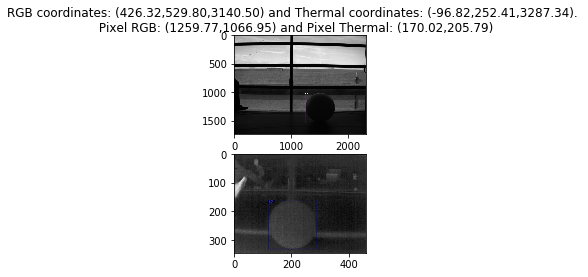

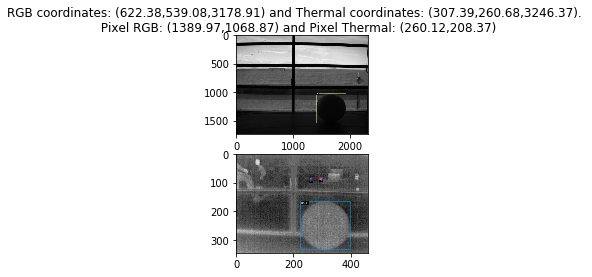

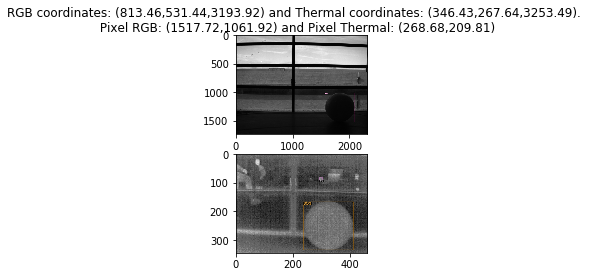

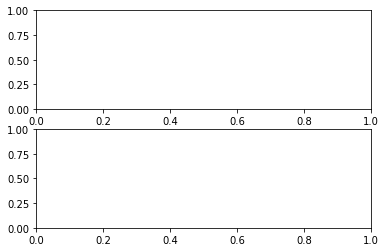

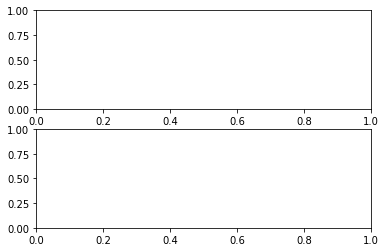

In [82]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
#read txt files with image path
# txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/bag2/", "bag2_rgb.txt")
txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")

f_rgb = open(txt_file_rgb, "r")

txt_file_ir = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
f_ir = open(txt_file_ir, "r")

#iniciate 3d plot


#initiate vectors
Xt=[]
Yt=[]
Zt=[]
Xr=[]
Yr=[]
Zr=[]
xpi=[]
ypi=[]
xpr=[]
ypr=[]
c=0

#for each figure in the path
for line_rgb in f_rgb: 
# read images and calculate detected bounding box for each camera

    im_rgb = cv2.imread(line_rgb[:len(line_rgb)-1])
    outputs_rgb = predictor(im_rgb)
    results_rgb=outputs_rgb["instances"].to("cpu")
    
    line_ir=f_ir.readline()
    im_ir = cv2.imread(line_ir[:len(line_ir)-1])
    outputs_ir = predictor(im_ir)
    results_ir=outputs_ir["instances"].to("cpu")


# CALCULATE CENTERS - remove images without detection in both timestamp
    if(len(results_rgb)!=0 and len(results_ir)!=0 ):
        coordinates_ir=results_ir.pred_boxes.tensor[0].numpy()
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        
        cond1=(abs((coordinates_rgb[2]-coordinates_rgb[0])-(coordinates_rgb[3]-coordinates_rgb[1]))>=0.05*max((coordinates_rgb[2]-coordinates_rgb[0]),(coordinates_rgb[3]-coordinates_rgb[1])))
        cond2=(abs((coordinates_ir[2]-coordinates_ir[0])-(coordinates_ir[3]-coordinates_ir[1]))>=0.05*max((coordinates_ir[2]-coordinates_ir[0]),(coordinates_ir[3]-coordinates_ir[1])))

        if(cond1==False and cond2==False):
            fig, axs = plt.subplots(2)

            #VISUAL
            xc_rgb=(coordinates_rgb[2]-coordinates_rgb[0])/2+coordinates_rgb[0]
            yc_rgb=(coordinates_rgb[3]-coordinates_rgb[1])/2+coordinates_rgb[1]
            xc_rgb=float("%0.2f"%xc_rgb)
            yc_rgb=float("%0.2f"%yc_rgb)

            dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
            dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
            d_pix_rgb=(dx_rgb+dy_rgb)/2

            Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
            X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
            Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb      

            #IR
            xc=(coordinates_ir[2]-coordinates_ir[0])/2+coordinates_ir[0]
            yc=(coordinates_ir[3]-coordinates_ir[1])/2+coordinates_ir[1]
            xc=float("%0.2f"%xc)
            yc=float("%0.2f"%yc)

            dx=float("%0.2f"%(float("%0.2f"%coordinates_ir[2])-float("%0.2f"%coordinates_ir[0])))
            dy=float("%0.2f"%(float("%0.2f"%coordinates_ir[3])-float("%0.2f"%coordinates_ir[1])))
            d_pix=(dx+dy)/2

            Z_ir=((fx+fy)/2)*(d_real/d_pix)
            X_ir=(Z_ir*(xc-cx))/fx
            Y_ir=(Z_ir*(yc-cy))/fy

            Xr.append(X_rgb)
            Yr.append(Y_rgb)
            Zr.append(Z_rgb)
            Xt.append(X_ir)
            Yt.append(Y_ir)
            Zt.append(Z_ir)   
            
                            
            v1= Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
            v1 = v1.draw_instance_predictions(results_rgb)
            axs[0].imshow(v1.get_image()[:, :, ::-1])

            v2= Visualizer(im_ir[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
            v2 = v2.draw_instance_predictions(results_ir)
            axs[1].imshow(v2.get_image()[:, :, ::-1])

            
            c+=1
#             print("RGB coordinates: (%f,%f,%f)" % (X_rgb,Y_rgb,Z_rgb))
#             print("Thermal coordinates: (%f,%f,%f)" % (X_ir,Y_ir,Z_ir))
#             print("(%.2f,%.2f)" % (xc_rgb,yc_rgb))
            fig.suptitle("RGB coordinates: (%.2f,%.2f,%.2f) and Thermal coordinates: (%.2f,%.2f,%.2f). \n Pixel RGB: (%.2f,%.2f) and Pixel Thermal: (%.2f,%.2f)" % (X_rgb,Y_rgb,Z_rgb,X_ir,Y_ir,Z_ir,xc_rgb,yc_rgb,xc,yc))
        
f_ir.close()        
f_rgb.close()
print(c)

In [78]:
objectPoints1=np.array([Xr,Yr,Zr]).T
objectPoints2=np.array([Xt,Yt,Zt]).T
(objectPoints1).shape
# print(len(Xr))
print (len(objectPoints1))


#             print("RGB coordinates: (%f,%f,%f)" % (X_rgb,Y_rgb,Z_rgb))
#             print("Thermal coordinates: (%f,%f,%f)" % (X_ir,Y_ir,Z_ir))


41


In [79]:
retval, Rt, inliers=cv2.estimateAffine3D(objectPoints1,objectPoints2,confidence=0.7)
# Rt=np.concatenate([Rt.T,np.array([0,0,0,1])])
Rt=np.vstack([Rt,np.array([0,0,0,1])])
print(inliers.T)
print(Rt)


[[0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0]]
[[-2.18208562e-01  1.54984198e+01  7.34759107e-02 -8.78537367e+03]
 [ 1.41529409e-02 -6.28706566e-02 -1.95860087e-01  9.01625969e+02]
 [ 3.99958964e-01 -8.25622966e+00  7.34041938e-01  5.42573314e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [80]:
objectPoints_mult=np.concatenate([objectPoints2, np.ones((len(objectPoints1), 1))], axis=1)
rotatedPoints= (Rt @ objectPoints_mult.T).T
print (objectPoints_mult.T.shape)

(4, 41)


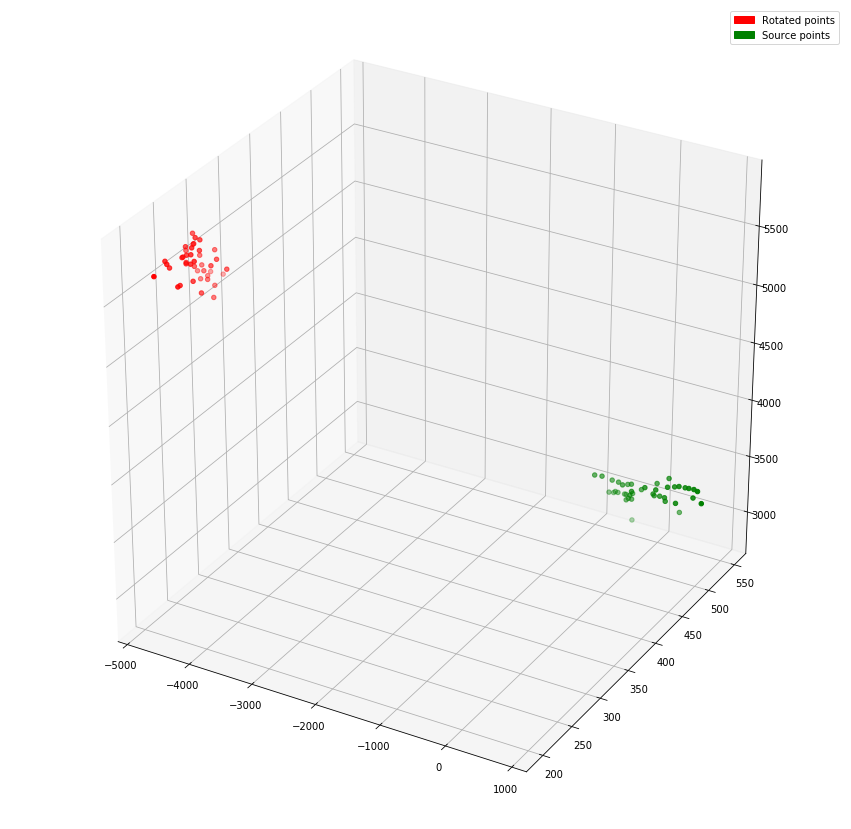

In [81]:
fig2 = plt.figure(figsize=(15,15))
ax2 = fig2.add_subplot(111, projection='3d' )
blue_patch = mpatches.Patch(color='green', label='Source points')
red_patch = mpatches.Patch(color='red', label='Rotated points')
plt.legend(handles=[red_patch,blue_patch])


ax2.scatter(rotatedPoints[:,0],rotatedPoints[:,1],rotatedPoints[:,2], c='r')
ax2.scatter(objectPoints1[:,0],objectPoints1[:,1],objectPoints1[:,2], c='g')